In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2 
import copy

In [2]:
IMAGE_PATH = '/kaggle/input/galaxy-zoo-dataset/images_training_rev1/images_training_rev1'
LABEL_PATH = '/kaggle/input/galaxy-zoo-dataset/training_solutions_rev1/training_solutions_rev1.csv'
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001 
FINE_TUNE_LR = 0.0001 
HEAD_EPOCHS = 2   
FINETUNE_EPOCHS = 3 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
class EnhanceContrast(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

    def __call__(self, img):
        np_img = np.array(img)
        lab_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab_img)
        # Apply CLAHE
        l_clahe = self.clahe.apply(l)
        updated_lab_img = cv2.merge((l_clahe, a, b))
        enhanced_img = cv2.cvtColor(updated_lab_img, cv2.COLOR_LAB2RGB)
        return Image.fromarray(enhanced_img)

class ApplyPseudoMask(object):
    def __call__(self, img):
        np_img = np.array(img)
        gray_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        masked_img = cv2.bitwise_and(np_img, np_img, mask=mask)
        return Image.fromarray(masked_img)

In [4]:
class GalaxyZooDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.image_paths = self.df['ImagePath'].values
        self.labels = self.df['target'].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            original_image_tensor = transforms.ToTensor()(image) 
        except FileNotFoundError:
            return None

        if self.transform:
            image = self.transform(image)
        
        label = torch.FloatTensor(self.labels[idx])
        return original_image_tensor, image, label

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch: return torch.Tensor(), torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

labels_df = pd.read_csv(LABEL_PATH)
labels_df['target'] = list(zip(labels_df['Class1.1'], labels_df['Class1.2']))
labels_df['ImagePath'] = labels_df['GalaxyID'].apply(lambda x: os.path.join(IMAGE_PATH, str(x) + '.jpg'))

train_df = labels_df.sample(frac=0.8, random_state=42)
val_df = labels_df.drop(train_df.index)

data_transforms = transforms.Compose([
    EnhanceContrast(),
    ApplyPseudoMask(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = GalaxyZooDataset(train_df, transform=data_transforms)
val_dataset = GalaxyZooDataset(val_df, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [5]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

model = model.to(DEVICE)
criterion = nn.MSELoss()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


In [6]:
def train_model(model, criterion, head_epochs, finetune_epochs):
    optimizer = optim.Adam(model.classifier[1].parameters(), lr=LEARNING_RATE)

#head training (sus)
    for epoch in range(head_epochs):
        print(f'Epoch {epoch+1}/{head_epochs}')
        model.train()
        train_loop = tqdm(train_loader, desc="Training Head")
        for _, inputs, labels in train_loop:
            if inputs.size(0) == 0: continue
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loop.set_postfix(loss=loss.item())

#Fine tuning
    for param in model.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(model.parameters(), lr=FINE_TUNE_LR)
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    
    for epoch in range(finetune_epochs):
        print(f'Epoch {epoch+1}/{finetune_epochs}')
        model.train()
        train_loop = tqdm(train_loader, desc="Fine-Tuning")
        for _, inputs, labels in train_loop:
            if inputs.size(0) == 0: continue
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loop.set_postfix(loss=loss.item())

        model.eval()
        running_loss, running_corrects = 0.0, 0
        val_loop = tqdm(val_loader, desc="Validating")
        with torch.no_grad():
            for _, inputs, labels in val_loop:
                if inputs.size(0) == 0: continue
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                _, true_classes = torch.max(labels, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == true_classes)
        
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        scheduler.step(val_loss)
        
    return model

model = train_model(model, criterion, HEAD_EPOCHS, FINETUNE_EPOCHS)

Epoch 1/2


Training Head: 100%|██████████| 1540/1540 [17:50<00:00,  1.44it/s, loss=0.0587]


Epoch 2/2


Training Head: 100%|██████████| 1540/1540 [11:37<00:00,  2.21it/s, loss=0.0577]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/3


Validating: 100%|██████████| 385/385 [04:55<00:00,  1.30it/s]


Validation Loss: 0.0277 Acc: 0.8379
Epoch 2/3


Validating: 100%|██████████| 385/385 [02:54<00:00,  2.20it/s]


Validation Loss: 0.0245 Acc: 0.8495
Epoch 3/3


Validating: 100%|██████████| 385/385 [02:53<00:00,  2.22it/s]

Validation Loss: 0.0227 Acc: 0.8528


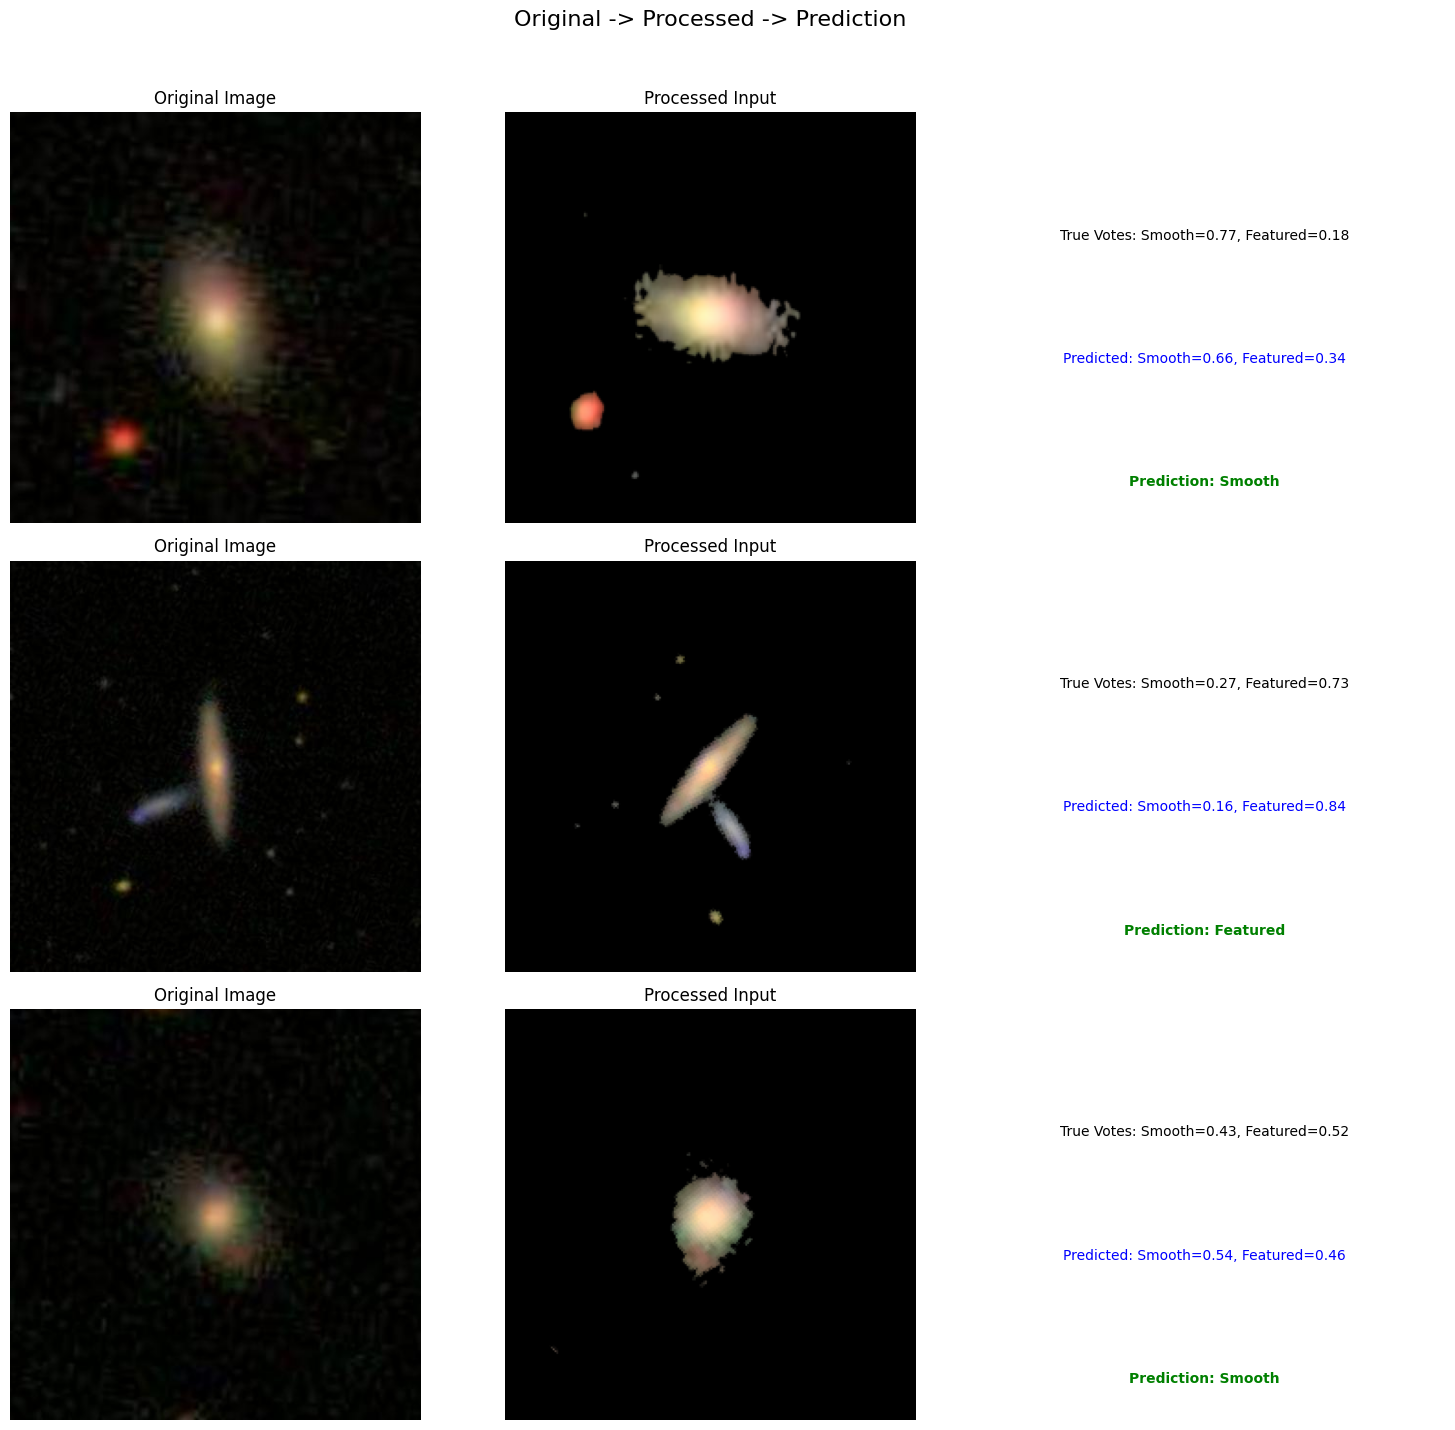

In [7]:
def visualize_prediction(model, loader, num_samples=3):
    model.eval()
    original_images, model_images, labels = next(iter(loader))
    
    with torch.no_grad():
        outputs = model(model_images.to(DEVICE))
    
    predictions = outputs.cpu().numpy()
    
    plt.figure(figsize=(15, 5 * num_samples))
    plt.suptitle("Original -> Processed -> Prediction", fontsize=16)

    for i in range(num_samples):
        ax = plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(original_images[i].permute(1, 2, 0))
        plt.title("Original Image")
        plt.axis("off")

        ax = plt.subplot(num_samples, 3, i * 3 + 2)
        img_for_display = model_images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_for_display = std * img_for_display + mean
        img_for_display = np.clip(img_for_display, 0, 1)
        plt.imshow(img_for_display)
        plt.title("Processed Input")
        plt.axis("off")

        # Predictions
        ax = plt.subplot(num_samples, 3, i * 3 + 3)
        true_label = labels[i].numpy()
        pred_label = predictions[i]
        pred_class = "Smooth" if pred_label[0] > pred_label[1] else "Featured"
        
        ax.text(0.5, 0.7, f"True Votes: Smooth={true_label[0]:.2f}, Featured={true_label[1]:.2f}", 
                ha='center', va='center')
        ax.text(0.5, 0.4, f"Predicted: Smooth={pred_label[0]:.2f}, Featured={pred_label[1]:.2f}",
                ha='center', va='center', color='blue')
        ax.text(0.5, 0.1, f"Prediction: {pred_class}",
                ha='center', va='center', weight='bold', color='green')
        plt.axis("off")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

visualize_prediction(model, val_loader)
